In [1]:
# ------------ Import Libraries ------------
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import timm
from tqdm import tqdm
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
print("OK")

OK


In [2]:
# --------- Initialize Parameters -------------
num_classes = 10# dataset includes 10 classes
epochs = 20
learning_rate = 0.001
batch_size = 64
weight_decay = 0.0005
model_name = "efficientvit_m2"
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# --------- Select CPU or GPU to run ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#--------- Check the name of the GPU --------
if torch.cuda.is_available():
    print(f"GPU name: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU name: Tesla V100-SXM2-32GB


In [3]:
#---------- Processing Data --------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dir = "/home/users/dtran/eurosat/dataset/train"
val_dir = "/home/users/dtran/eurosat/dataset/test"

train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
print("OK")

OK


In [4]:
# ------------- Model ------------------
model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

print("Model OK")

Model OK


In [5]:
#---------------- Training -------------------
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]")
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    scheduler.step()
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    val_loss = val_loss / len(val_loader)
    val_losses.append(val_loss)

    val_accuracy = accuracy_score(y_true, y_pred) * 100
    val_accuracies.append(val_accuracy)

    print(f"\nEpoch {epoch+1} - Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%")
    print(f"\nEpoch {epoch+1} - Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%\n")

Epoch [1/20]: 100%|██████████████████████████████████████████████| 338/338 [01:18<00:00,  4.30it/s, accuracy=90.1, loss=0.273]



Epoch 1 - Train Loss: 0.3567, Train Acc: 90.06%

Epoch 1 - Val Loss: 0.2418, Val Acc: 91.57%



Epoch [2/20]: 100%|█████████████████████████████████████████████| 338/338 [00:48<00:00,  6.92it/s, accuracy=94.7, loss=0.0849]



Epoch 2 - Train Loss: 0.1639, Train Acc: 94.65%

Epoch 2 - Val Loss: 0.3653, Val Acc: 89.52%



Epoch [3/20]: 100%|██████████████████████████████████████████████| 338/338 [00:51<00:00,  6.60it/s, accuracy=95.3, loss=0.157]



Epoch 3 - Train Loss: 0.1463, Train Acc: 95.33%

Epoch 3 - Val Loss: 0.1826, Val Acc: 93.87%



Epoch [4/20]: 100%|█████████████████████████████████████████████| 338/338 [00:49<00:00,  6.78it/s, accuracy=95.9, loss=0.0735]



Epoch 4 - Train Loss: 0.1305, Train Acc: 95.86%

Epoch 4 - Val Loss: 0.1470, Val Acc: 95.70%



Epoch [5/20]: 100%|██████████████████████████████████████████████| 338/338 [00:50<00:00,  6.75it/s, accuracy=96.2, loss=0.052]



Epoch 5 - Train Loss: 0.1163, Train Acc: 96.15%

Epoch 5 - Val Loss: 0.1356, Val Acc: 95.63%



Epoch [6/20]: 100%|██████████████████████████████████████████████| 338/338 [00:49<00:00,  6.84it/s, accuracy=96.2, loss=0.339]



Epoch 6 - Train Loss: 0.1147, Train Acc: 96.22%

Epoch 6 - Val Loss: 0.1386, Val Acc: 95.43%



Epoch [7/20]: 100%|██████████████████████████████████████████████| 338/338 [00:50<00:00,  6.75it/s, accuracy=96.4, loss=0.329]



Epoch 7 - Train Loss: 0.1059, Train Acc: 96.45%

Epoch 7 - Val Loss: 0.1086, Val Acc: 96.61%



Epoch [8/20]: 100%|█████████████████████████████████████████████| 338/338 [00:49<00:00,  6.86it/s, accuracy=98.9, loss=0.0153]



Epoch 8 - Train Loss: 0.0420, Train Acc: 98.86%

Epoch 8 - Val Loss: 0.0585, Val Acc: 98.04%



Epoch [9/20]: 100%|████████████████████████████████████████████| 338/338 [00:49<00:00,  6.79it/s, accuracy=99.3, loss=0.00613]



Epoch 9 - Train Loss: 0.0281, Train Acc: 99.26%

Epoch 9 - Val Loss: 0.0544, Val Acc: 98.22%



Epoch [10/20]: 100%|████████████████████████████████████████████| 338/338 [00:49<00:00,  6.79it/s, accuracy=99.6, loss=0.0323]



Epoch 10 - Train Loss: 0.0188, Train Acc: 99.60%

Epoch 10 - Val Loss: 0.0515, Val Acc: 98.07%



Epoch [11/20]: 100%|████████████████████████████████████████████| 338/338 [00:49<00:00,  6.78it/s, accuracy=99.7, loss=0.0919]



Epoch 11 - Train Loss: 0.0139, Train Acc: 99.72%

Epoch 11 - Val Loss: 0.0539, Val Acc: 98.13%



Epoch [12/20]: 100%|████████████████████████████████████████████| 338/338 [00:49<00:00,  6.81it/s, accuracy=99.8, loss=0.0788]



Epoch 12 - Train Loss: 0.0115, Train Acc: 99.79%

Epoch 12 - Val Loss: 0.0537, Val Acc: 98.26%



Epoch [13/20]: 100%|████████████████████████████████████████████| 338/338 [00:50<00:00,  6.71it/s, accuracy=99.8, loss=0.0249]



Epoch 13 - Train Loss: 0.0107, Train Acc: 99.82%

Epoch 13 - Val Loss: 0.0641, Val Acc: 97.93%



Epoch [14/20]: 100%|███████████████████████████████████████████| 338/338 [00:50<00:00,  6.64it/s, accuracy=99.9, loss=0.00365]



Epoch 14 - Train Loss: 0.0079, Train Acc: 99.88%

Epoch 14 - Val Loss: 0.0546, Val Acc: 98.39%



Epoch [15/20]: 100%|████████████████████████████████████████████| 338/338 [00:49<00:00,  6.76it/s, accuracy=99.9, loss=0.0094]



Epoch 15 - Train Loss: 0.0057, Train Acc: 99.92%

Epoch 15 - Val Loss: 0.0529, Val Acc: 98.41%



Epoch [16/20]: 100%|████████████████████████████████████████████| 338/338 [00:49<00:00,  6.78it/s, accuracy=100, loss=0.00813]



Epoch 16 - Train Loss: 0.0046, Train Acc: 99.97%

Epoch 16 - Val Loss: 0.0536, Val Acc: 98.28%



Epoch [17/20]: 100%|███████████████████████████████████████████| 338/338 [00:50<00:00,  6.67it/s, accuracy=99.9, loss=0.00378]



Epoch 17 - Train Loss: 0.0050, Train Acc: 99.94%

Epoch 17 - Val Loss: 0.0551, Val Acc: 98.35%



Epoch [18/20]: 100%|███████████████████████████████████████████| 338/338 [00:50<00:00,  6.67it/s, accuracy=99.9, loss=0.00223]



Epoch 18 - Train Loss: 0.0047, Train Acc: 99.95%

Epoch 18 - Val Loss: 0.0548, Val Acc: 98.24%



Epoch [19/20]: 100%|█████████████████████████████████████████████| 338/338 [00:50<00:00,  6.63it/s, accuracy=100, loss=0.0117]



Epoch 19 - Train Loss: 0.0041, Train Acc: 99.97%

Epoch 19 - Val Loss: 0.0541, Val Acc: 98.31%



Epoch [20/20]: 100%|█████████████████████████████████████████████| 338/338 [00:50<00:00,  6.70it/s, accuracy=100, loss=0.0457]



Epoch 20 - Train Loss: 0.0042, Train Acc: 99.97%

Epoch 20 - Val Loss: 0.0555, Val Acc: 98.37%



In [6]:
#---------------- Save Model -----------------
torch.save(model.state_dict(), os.path.join(results_dir, f"{model_name}_trained.pth"))
print("Saved model")

Saved model


In [7]:
#--------------- Evaluation -----------------
start_time = time.time()
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

inference_time = time.time() - start_time

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)

print(f"Final Results: Accuracy={accuracy:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, Inference Time={inference_time:.2f}s")

Final Results: Accuracy=0.9837, Precision=0.9834, Recall=0.9830, Inference Time=9.16s


In [8]:
#--------------- Save Results to a csv file ------------------
csv_file = os.path.join(results_dir, "eval_results.csv")
file_exists = os.path.isfile(csv_file)

with open(csv_file, mode="a", newline="") as f:
    writer = csv.writer(f)
    if not file_exists:
        writer.writerow(["Model", "Accuracy", "Precision", "Recall", "Inference_Time"])
    writer.writerow([model_name, accuracy, precision, recall, inference_time])

print("Saved Results")

Saved Results


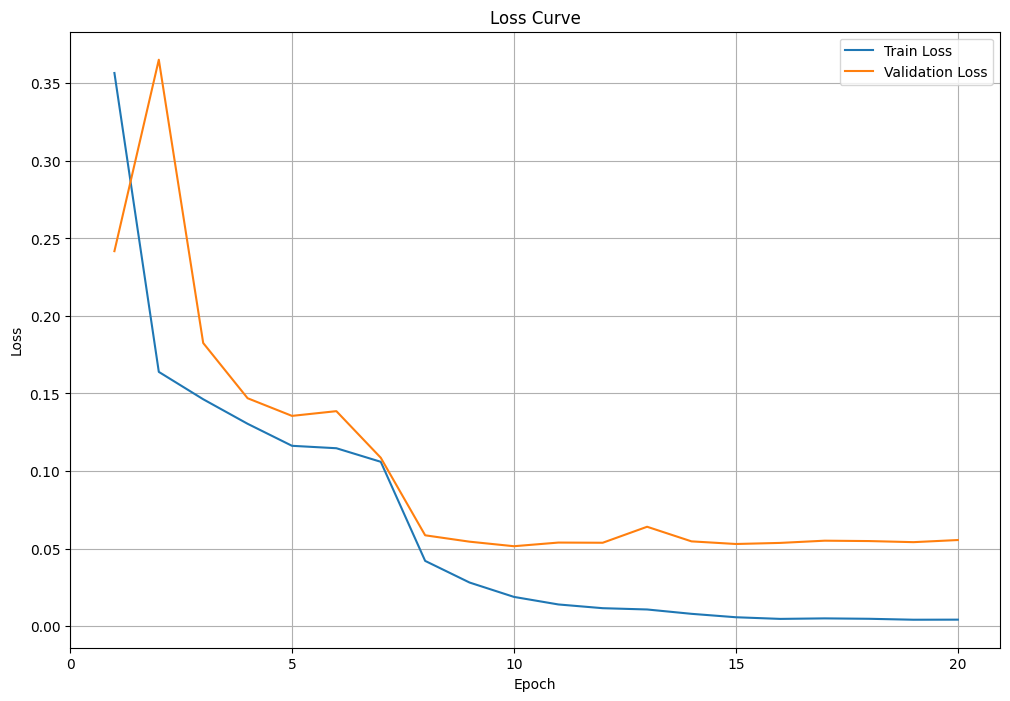

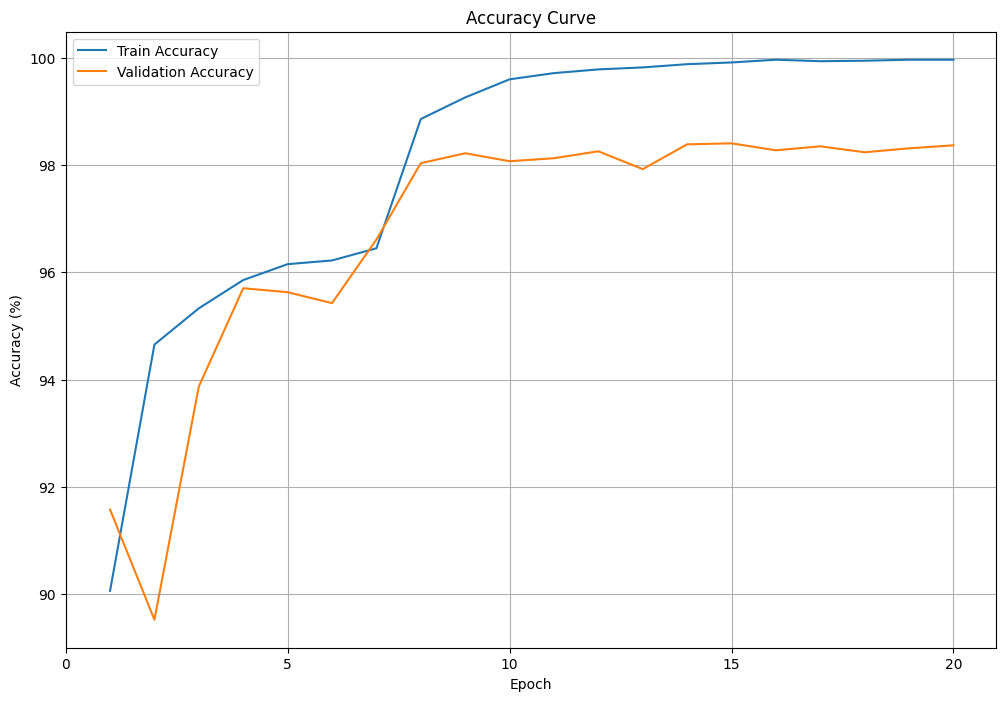

<Figure size 1200x800 with 0 Axes>

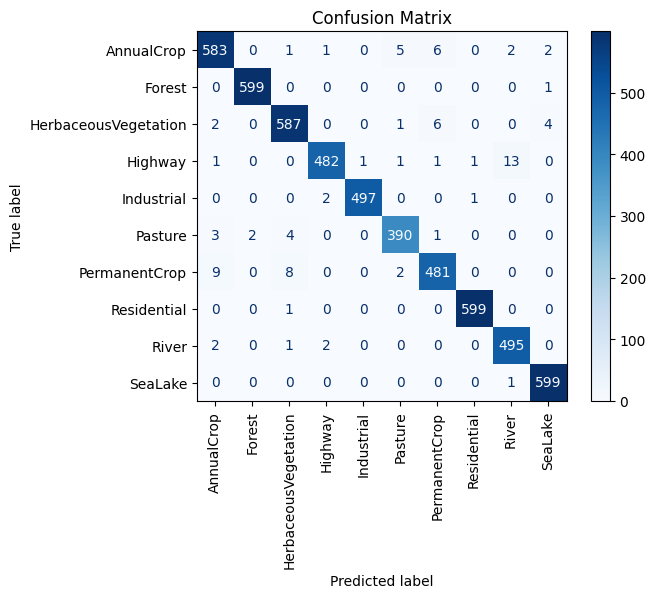

In [12]:
#---------------- Plotting -----------------
import numpy as np
# Train/Val Loss
plt.figure(figsize=(12,8), num=1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(np.arange(0, epochs+1, 5))
plt.legend()
plt.grid()
plt.title('Loss Curve')
plt.savefig(os.path.join(results_dir, "loss_curve.png"))

# Train/Val Accuracy
plt.figure(figsize=(12,8), num=2)
plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epochs+1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.xticks(np.arange(0, epochs+1, 5))
plt.legend()
plt.grid()
plt.title('Accuracy Curve')
plt.savefig(os.path.join(results_dir, "accuracy_curve.png"))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,8), num=3)
ConfusionMatrixDisplay(cm, display_labels=val_dataset.classes).plot(values_format='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.savefig(os.path.join(results_dir, "confusion_matrix.png"))